In [1]:
%run ./utils.ipynb

In [2]:
# Hyperparameters
mult = 1 # channel multiplier for transposed convolutions
folds_to_train = range(n_splits)
k = 4

In [3]:
sz = 202
max_crop_sz = int(sz * 0.9)

trn_tfms = albumentations.Compose([
    albumentations.HorizontalFlip(),
    albumentations.RandomSizedCrop((max_crop_sz, max_crop_sz), sz, sz, interpolation=1, p=0.5),
    albumentations.IAAAffine(rotate=10, p=0.5, mode='edge'),
    albumentations.Blur()
])

In [4]:
base_tfms = albumentations.Compose([
    albumentations.PadIfNeeded(256, 256)
])

def get_data_bunch(sz=128, bs=64, part=0, trn_tfms=trn_tfms):
    trn_ds = FilesDataset(PATH/TRAIN_DN, sz, take_idxs=trn_parts[part], tfms=albumentations.Compose([trn_tfms, base_tfms]))
    val_ds = FilesDataset(PATH/TRAIN_DN, sz, take_idxs=val_parts[part], tfms=base_tfms)
    tst_ds = FilesDataset(PATH/TEST_DN, sz, tfms=base_tfms)
    
    trn_dl = DataLoader(trn_ds, bs, True, num_workers=11, pin_memory=True)
    val_dl = DataLoader(val_ds, bs, False, num_workers=11, pin_memory=True)
    tst_dl = DataLoader(tst_ds, bs, False, num_workers=11, pin_memory=True)
    
    trn_dl, val_dl, tst_dl = map(lambda ts: DeviceDataLoader(*ts), zip([trn_dl, val_dl, tst_dl], [default_device] * 3) )
    return DataBunch(trn_dl, val_dl, tst_dl, default_device)

def predict(model, dl, flip=True):
    model.eval()
    preds = [torch.sigmoid(model(xb)).detach().cpu().numpy()[:, 27:-27, 27:-27] for xb, yb in dl]
    preds = np.concatenate(preds)
    if not flip: return preds
    flipped_preds = np.concatenate([torch.sigmoid(model(torch.flip(xb, [3]))).detach().cpu().numpy()[:, 27:-27, 27:-27] for xb, yb in dl])
    preds = (preds + flipped_preds[:,:,::-1]) / 2
    return preds

def predict_with_TTA(model, dl, upside_down=True):
    model.eval()
    
    preds = np.concatenate([torch.sigmoid(model(xb)).detach().cpu().numpy()[:, 27:-27, 27:-27] for xb, yb in dl])
    if upside_down: preds_upside_down = np.concatenate([torch.sigmoid(model(torch.flip(xb, [2]))).detach().cpu().numpy()[:, 27:-27, 27:-27] for xb, yb in dl])
    
    flipped_preds = np.concatenate([torch.sigmoid(model(torch.flip(xb, [3]))).detach().cpu().numpy()[:, 27:-27, 27:-27] for xb, yb in dl])
    if upside_down: flipped_preds_upside_down = np.concatenate([torch.sigmoid(model(torch.flip(xb, [1, 3]))).detach().cpu().numpy()[:, 27:-27, 27:-27] for xb, yb in dl])
    
    preds = (preds + flipped_preds[:,:,::-1]) / 2
    if upside_down: preds = 0.5 * preds + (preds_upside_down[:,::-1,:] + flipped_preds_upside_down[:,::-1,::-1]) / 4 
    return preds

def predict_with_targs_and_TTA(model, dl, upside_down=True):
    preds = predict_with_TTA(model, dl, upside_down)
    targs = np.concatenate([yb.detach().cpu().numpy()[:, 27:-27, 27:-27] for xb, yb in dl])
    return preds, targs

def accuracy_no_pad(preds, targs):
    return accuracy_thresh(preds[:, 27:-27, 27:-27], targs[:, 27:-27, 27:-27])

def dice_no_pad(preds, targs):
    return dice(preds[:, 27:-27, 27:-27], targs[:, 27:-27, 27:-27])

def iou_pytorch(out, yb):
    preds = out > 0
    return torch.tensor(iou_metric(yb.cpu().numpy()[:, 27:-27, 27:-27], preds.cpu().numpy()[:, 27:-27, 27:-27]))

In [5]:
class UnetBlock(nn.Module):
    def __init__(self, up_in, x_in, n_out):
        super().__init__()
        up_out = x_out = n_out//2
        self.x_conv  = nn.Conv2d(x_in,  x_out,  1)
        self.tr_conv = nn.ConvTranspose2d(up_in, up_out, k, stride=2, padding=(k-2)//2)
        self.bn = nn.BatchNorm2d(n_out)
        self.out_channels = n_out
        
    def forward(self, up_p, x_p):
        up_p = self.tr_conv(up_p)
        x_p = self.x_conv(x_p)
        cat_p = torch.cat([up_p,x_p], dim=1)
        return self.bn(F.relu(cat_p))
    
class UnetSE_res50(nn.Module):        
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.sfs = [SaveFeatures(rn[i]) for i in range(4)]
        self.up1 = UnetBlock(2048,1024,768)
        self.up2 = UnetBlock(768,512,320)
        self.up3 = UnetBlock(320,256 + 64,160)
        self.up4 = nn.ConvTranspose2d(160, 48, k, stride=2, padding=(k-2)//2)
        self.up4_bn = nn.BatchNorm2d(48)
        self.up5 = UnetBlock(48,3,32)
        
        self.se1 = scSELayer(self.up1.out_channels)
        self.se2 = scSELayer(self.up2.out_channels)
        self.se3 = scSELayer(self.up3.out_channels)
        self.se4 = scSELayer(48)
        self.se5 = scSELayer(self.up5.out_channels)
        
        self.se_feat1 = scSELayer(256 + 64)
        self.se_feat2 = scSELayer(512)
        self.se_feat3 = scSELayer(1024)
        
        self.hc1 = HCBlock(self.up1.out_channels)
        self.hc2 = HCBlock(self.up2.out_channels)
        self.hc3 = HCBlock(self.up3.out_channels)
        self.hc4 = HCBlock(48)
        
        self.hc_comb = nn.Conv2d(64, 8, 3, padding=1)
        self.hc_bn = nn.BatchNorm2d(8)
        
        self.up6 = nn.ConvTranspose2d(32 + 8, 1, 1)
        
    def forward(self,x):
        inp = x
        x = F.relu(self.rn(x))
        x = self.up1(x, self.se_feat3(self.sfs[3].features))
        x = self.se1(x)
        hc1 = self.hc1(x)
        
        x = self.up2(x, self.se_feat2(self.sfs[2].features))
        x = self.se2(x)
        hc2 = self.hc2(x)
        
        feats = torch.cat((self.sfs[0].features, self.sfs[1].features), dim=1)
        x = self.up3(x, self.se_feat1(feats))
        x = self.se3(x)
        hc3 = self.hc3(x)
        
        x = F.relu(self.up4_bn(self.up4(x)))
        x = self.se4(x)
        hc4 = self.hc4(x)
        
        x = self.up5(x, inp)
        x = self.se5(x)
        
        hc = self.hc_comb(torch.cat((hc1, hc2, hc3, hc4), dim=1))
        hc = self.hc_bn(F.relu(hc))
        x = torch.cat((x, hc), dim=1)
        x = self.up6(x)
        return x[:,0]
    
    def close(self):
        for sf in self.sfs: sf.remove()

In [6]:
def get_learner(db):
    se_res50 = nn.Sequential(*list(pretrainedmodels.se_resnext50_32x4d().children())[:-2])
    m = UnetSE_res50(se_res50)
    m.cuda(default_device)
    learn = Learner(db, m, true_wd=True, loss_fn=bce_loss, opt_fn=lambda x: optim.SGD(x))
#     learn = Learner(db, m, true_wd=True, loss_fn=bce_loss, opt_fn=AdamW)
    learn.metrics = [accuracy_no_pad, dice_no_pad, iou_pytorch]
    learn.callbacks = [SaveBest()]
    return learn

In [5]:
# %%time
for fold in folds_to_train:
    print(f'### Starting to train fold {fold} ###')
    db = get_data_bunch(sz=202, bs=16, part=fold, trn_tfms=trn_tfms)
    learn = get_learner(db)
    requires_grad(learn.model, True)
    requires_grad(learn.model.rn, False)
    learn.fit_one_cycle(9, 1e-1)
    learn.unfreeze()
    learn.fit_one_cycle(40, 1e-2)
    learn.loss_fn = lovasz_loss
    learn.fit_one_cycle(40, 5e-3)
    learn.save(f'{name}_fold{fold}')

### Starting to train fold 0 ###
epoch  train loss  valid loss  accuracy_no_pad  dice_no_pad  iou_pytorch
0      0.292015    0.284441    0.893400         0.765132     0.479095   
1      0.253959    0.238934    0.916907         0.809451     0.600489   
2      0.239984    0.215250    0.921299         0.811561     0.673594   
3      0.225915    0.231175    0.908503         0.796814     0.617237   
4      0.199795    0.196116    0.929191         0.831452     0.677384   
7      0.177344    0.176710    0.937149         0.854180     0.726161   
8      0.166554    0.172456    0.937998         0.858530     0.722127   
epoch  train loss  valid loss  accuracy_no_pad  dice_no_pad  iou_pytorch
0      0.155714    0.167249    0.938719         0.860583     0.729584   
1      0.167333    0.171031    0.932695         0.839854     0.712225   
2      0.153857    0.157989    0.941205         0.862606     0.738509   
3      0.157417    0.166514    0.937934         0.852908     0.739364   
4      0.143205   

12     0.101597    0.132654    0.950968         0.897303     0.783827   
13     0.096382    0.129984    0.951010         0.900368     0.782839   
14     0.099245    0.148545    0.944296         0.884735     0.763704   
15     0.099558    0.134252    0.950512         0.900564     0.780617   
16     0.105318    0.146388    0.945826         0.895072     0.763086   
17     0.090598    0.125598    0.954454         0.904975     0.789383   
18     0.104562    0.147583    0.951103         0.903404     0.774691   
19     0.095380    0.126469    0.958693         0.911330     0.799877   
20     0.082374    0.175980    0.940526         0.878232     0.760000   
21     0.084462    0.118311    0.957002         0.912688     0.790741   
22     0.079177    0.141188    0.952311         0.901076     0.785802   
23     0.072018    0.122202    0.959111         0.914561     0.789630   
24     0.070412    0.125976    0.959648         0.917346     0.791111   
25     0.064773    0.138613    0.951954         0.8

32     0.069241    0.130908    0.959344         0.914335     0.788317   
33     0.055058    0.113291    0.963365         0.924636     0.788442   
34     0.050961    0.118900    0.961221         0.922391     0.782412   
35     0.050907    0.114355    0.961734         0.920464     0.786683   
36     0.054301    0.127416    0.955649         0.909541     0.775251   
37     0.043234    0.120443    0.959238         0.915377     0.779899   
38     0.043766    0.118285    0.961378         0.919641     0.784422   
39     0.043657    0.116251    0.961393         0.919486     0.785176   
epoch  train loss  valid loss  accuracy_no_pad  dice_no_pad  iou_pytorch
0      0.349438    0.548896    0.958247         0.914122     0.774874   
1      0.317679    0.529517    0.955818         0.905428     0.775000   
2      0.276960    0.479133    0.948324         0.894627     0.782161   
3      0.355264    0.511307    0.953570         0.902747     0.767085   
4      0.305606    0.452097    0.955725         0.9

11     0.466803    0.434028    0.944607         0.879306     0.754362   
12     0.408035    0.397253    0.957798         0.910830     0.784576   
13     0.338551    0.378640    0.955105         0.909425     0.790771   
14     0.341515    0.403127    0.953351         0.899155     0.779140   
15     0.306665    0.351109    0.959846         0.917627     0.803540   
16     0.297312    0.366306    0.953602         0.906867     0.797977   
17     0.309059    0.363109    0.958605         0.916138     0.805310   
18     0.280014    0.370274    0.953803         0.906348     0.796207   
19     0.259707    0.352134    0.956494         0.906749     0.803161   
20     0.263348    0.362767    0.953175         0.895242     0.800253   
21     0.259242    0.347158    0.958804         0.919124     0.802781   
22     0.246756    0.329762    0.961557         0.918823     0.810240   
23     0.257627    0.344757    0.959870         0.916120     0.806827   
24     0.240486    0.341810    0.960732         0.9

32     0.170452    0.267429    0.961744         nan          0.845860   
33     0.151671    0.255015    0.964170         nan          0.853376   
34     0.152295    0.252835    0.964984         nan          0.854904   
35     0.155099    0.248925    0.964353         nan          0.852484   
36     0.143878    0.257782    0.964240         nan          0.854268   
37     0.153231    0.251785    0.962975         nan          0.854013   
38     0.145596    0.251433    0.961087         nan          0.852611   
39     0.154005    0.246733    0.965504         nan          0.856051   


In [7]:
%%time

upside_down = False

for fold in folds_to_train:
    db = get_data_bunch(sz=202, bs=16, part=fold, trn_tfms=trn_tfms)
    learn = get_learner(db)
    
    learn.load(f'{name}_fold{fold}')
    val_preds, val_targs = predict_with_targs_and_TTA(learn.model, db.valid_dl, upside_down)
    test_preds = predict_with_TTA(learn.model, db.test_dl, upside_down)
    val_preds, test_preds = normalize_t(val_preds, val_targs, test_preds)
    print(f'Fold {fold} val acc: {accuracy_np(val_preds, val_targs)}, iou: {iou_metric(val_targs, val_preds > 0.5)}')
    
    
    np.save(f'/home/radek/db/salt/val_preds_{name}_fold{fold}', val_preds)
    np.save(f'/home/radek/db/salt/val_targs_{name}_fold{fold}', val_targs)
    np.save(f'/home/radek/db/salt/test_preds_{name}_fold{fold}', test_preds)
    del val_preds, val_targs, test_preds
    
    
    learn.load(f'{name}_best_iou_fold{fold}')
    val_preds, val_targs = predict_with_targs_and_TTA(learn.model, db.valid_dl, upside_down)
    test_preds = predict_with_TTA(learn.model, db.test_dl, upside_down)
    
    val_preds, test_preds = normalize_t(val_preds, val_targs, test_preds)
    print(f'Fold {fold} best iou val acc: {accuracy_np(val_preds, val_targs)}, iou: {iou_metric(val_targs, val_preds > 0.5)}')
    
    np.save(f'/home/radek/db/salt/val_preds_{name}_best_iou_fold{fold}', val_preds)
    np.save(f'/home/radek/db/salt/test_{name}_best_iou_fold{fold}', test_preds)
    del val_preds, val_targs, test_preds
    
    learn.model.close()
    del learn

Fold 0 val acc: 0.9501998222044965, iou: 0.845721271393643
Fold 0 best iou val acc: 0.9493975793158972, iou: 0.8458435207823961
Fold 1 val acc: 0.9632002611702314, iou: 0.847037037037037
Fold 1 best iou val acc: 0.9632002309141805, iou: 0.847037037037037
Fold 2 val acc: 0.9654787083638957, iou: 0.8310301507537688
Fold 2 best iou val acc: 0.9654787083638957, iou: 0.8310301507537688
Fold 3 val acc: 0.9635732026470224, iou: 0.8353982300884957
Fold 3 best iou val acc: 0.9646339610491572, iou: 0.8383059418457648
Fold 4 val acc: 0.9652535001876299, iou: 0.8547770700636943
Fold 4 best iou val acc: 0.9679710743982263, iou: 0.8596178343949044
CPU times: user 37min 49s, sys: 12min 46s, total: 50min 35s
Wall time: 47min 33s


In [8]:
%%time
ys = []
preds = []
test_preds = np.zeros((18000, 202, 202))
for fold in folds_to_train:
    y = np.load(f'/home/radek/db/salt/val_targs_{name}_fold{fold}.npy')
    val_preds = np.load(f'/home/radek/db/salt/val_preds_{name}_fold{fold}.npy')
    preds.append(val_preds)
    ys.append(y)
    test_pred = np.load(f'/home/radek/db/salt/test_preds_{name}_fold{fold}.npy')
    test_preds += test_pred / len(folds_to_train)

np.save(f'/home/radek/db/salt/val_preds_{name}.npy', np.concatenate(preds))
np.save(f'/home/radek/db/salt/val_targs_{name}.npy', np.concatenate(ys))
np.save(f'/home/radek/db/salt/test_preds_{name}.npy', test_preds)

CPU times: user 10.5 s, sys: 20.6 s, total: 31.1 s
Wall time: 57.8 s


In [13]:
%%time
for fold in folds_to_train:
    val_preds = np.load(f'/home/radek/db/salt/val_preds_{name}_fold{fold}.npy')
    val_targs = np.load(f'/home/radek/db/salt/val_targs_{name}_fold{fold}.npy')
    print(f'Fold {fold}: {accuracy_np(val_preds, val_targs)}, {iou_metric(val_targs, val_preds > 0.5)}, {best_preds_t(val_preds, val_targs)}')

Part 0: 0.9493975793158972, 0.8458435207823961, 0.49999999999999994
Part 1: 0.9632002611702314, 0.847037037037037, 0.49999999999999994
Part 2: 0.9654787083638957, 0.8310301507537688, 0.49999999999999994
Part 3: 0.9646339610491572, 0.8383059418457648, 0.49999999999999994
Part 4: 0.9679710743982263, 0.8596178343949044, 0.49999999999999994
CPU times: user 11.5 s, sys: 580 ms, total: 12.1 s
Wall time: 13.8 s


In [10]:
val_preds = np.load(f'/home/radek/db/salt/val_preds_{name}.npy')
val_targs = np.load(f'/home/radek/db/salt/val_targs_{name}.npy')

In [11]:
iou_metric(val_targs, val_preds > 0.5)

0.84435

In [19]:
val_preds = np.load(f'/home/radek/db/salt/val_preds_{name}_fold4.npy')
val_targs = np.load(f'/home/radek/db/salt/val_targs_{name}_fold4.npy')

In [20]:
iou_metric(val_targs, val_preds > 0.5)

0.8596178343949044

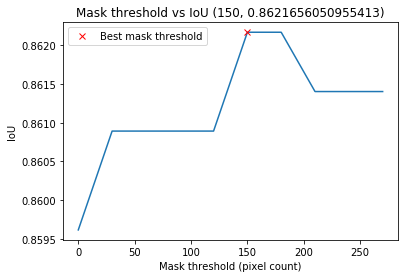

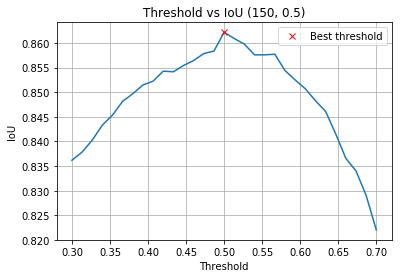

In [21]:
%run diagnostics.ipynb

In [22]:
test_preds = np.load(f'/home/radek/db/salt/test_preds_{name}_fold4.npy')

In [23]:
preds_to_sub(test_preds, db.test_dl.dl.dataset.x, 0.5, 150, name)

In [24]:
!kaggle competitions submit -c tgs-salt-identification-challenge -f ../subs/{name}.csv.gz  -m {name}

Successfully submitted to TGS Salt Identification Challenge